Data is originally from Kaggle dataset [Students Performance in Exams](https://www.kaggle.com/spscientist/students-performance-in-exams/home).

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy.stats as stats
from scipy.stats import ttest_ind


In [3]:
df = pd.read_csv('studentsperformance.csv')

#### A Quick Glance at the Data
At this point, I mostly want to make sure there aren't any missing values before starting to answer questions.  From the describe function, we see that there aren't any missing values.  Scores are in the expected range between 0 to 100, and from the unique values, there aren't any funny labels

In [4]:
df.describe(include = 'all')

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
count,1000,1000,1000,1000,1000,1000.00000,1000.000000,1000.000000
unique,2,5,6,2,2,NaN,NaN,NaN
top,female,group C,some college,standard,none,NaN,NaN,NaN
freq,518,319,226,645,642,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,66.08900,69.169000,68.054000
std,NaN,NaN,NaN,NaN,NaN,15.16308,14.600192,15.195657
min,NaN,NaN,NaN,NaN,NaN,0.00000,17.000000,10.000000
25%,NaN,NaN,NaN,NaN,NaN,57.00000,59.000000,57.750000
50%,NaN,NaN,NaN,NaN,NaN,66.00000,70.000000,69.000000
75%,NaN,NaN,NaN,NaN,NaN,77.00000,79.000000,79.000000


In [7]:
for col in df.columns:
    print(col, df[col].unique())

gender ['female' 'male']
race/ethnicity ['group B' 'group C' 'group A' 'group D' 'group E']
parental level of education ["bachelor's degree" 'some college' "master's degree" "associate's degree"
 'high school' 'some high school']
lunch ['standard' 'free/reduced']
test preparation course ['none' 'completed']
math score [ 72  69  90  47  76  71  88  40  64  38  58  65  78  50  18  46  54  66
  44  74  73  67  70  62  63  56  97  81  75  57  55  53  59  82  77  33
  52   0  79  39  45  60  61  41  49  30  80  42  27  43  68  85  98  87
  51  99  84  91  83  89  22 100  96  94  48  35  34  86  92  37  28  24
  26  95  36  29  32  93  19  23   8]
reading score [ 72  90  95  57  78  83  43  64  60  54  52  81  53  75  89  32  42  58
  69  73  71  74  70  65  87  56  61  84  55  44  41  85  59  17  39  80
  37  63  51  49  26  68  45  47  86  34  79  66  67  91 100  76  77  82
  92  93  62  88  50  28  48  46  23  38  94  97  99  31  96  24  29  40]
writing score [ 74  88  93  44  75  78  92 

### 1) Are there any differences between the genders, ethnicities, and parental level of education with respect to their performances in exams?

There are three subjects (math, reading, and writing) and 3 variables to examine for each subject (gender, race, parent's education).  I will be going through each variable to see if they play a role in subject scores.  

First though, I would like to check the distributions for math, reading, and writing scores.  From the describe function above, I already know that the scores are within bounds (between 0 and 100), but its always good to know the shape of the distribution as well.  

The distributions are plotted below.  They all have a slight left skew, with the peak centered at around 65-70, depending on the subject matter.  

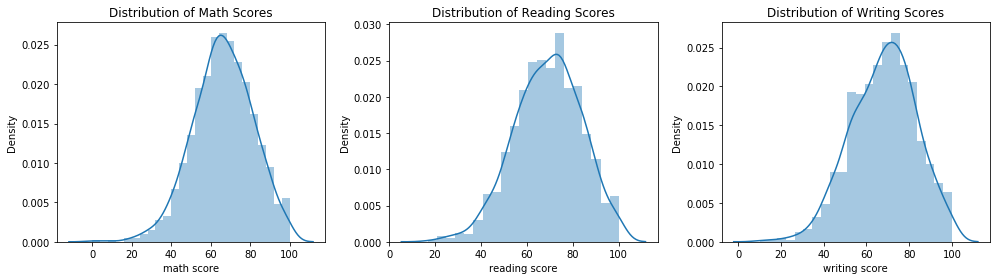

In [208]:
fig, (axis1, axis2, axis3) = plt.subplots(1,3,figsize=(14,4))

sns.distplot(df['math score'], ax = axis1)
sns.distplot(df['reading score'], ax = axis2)
sns.distplot(df['writing score'], ax = axis3)

axis1.set_title('Distribution of Math Scores')
axis2.set_title('Distribution of Reading Scores')
axis3.set_title('Distribution of Writing Scores')

for ax in [axis1, axis2, axis3]:
    ax.set_ylabel('Density')

plt.tight_layout()

In [210]:
print('Mean math score: {}'.format(df['math score'].mean()))
print('Median math score: {}\n'.format(df['math score'].median()))
print('Mean reading score: {}'.format(df['reading score'].mean()))
print('Median reading score: {}\n'.format(df['reading score'].median()))
print('Mean writing score: {}'.format(df['writing score'].mean()))
print('Median writing score: {}'.format(df['writing score'].median()))

Mean math score: 66.089
Median math score: 66.0

Mean reading score: 69.169
Median reading score: 70.0

Mean writing score: 68.054
Median writing score: 69.0


#### 1.1 - Gender
Next, I will go through each variable to see how they affect each subject score.  Below, I've plotted point plots for gender and math, reading, and writing scores.  

For math, it looks like males have a higher score than females, whereas females have a higher score than males for reading and writing.  The confidence intervals are relatively small, so it looks like they are significantly different.  But the best way to tell is through a t-test.

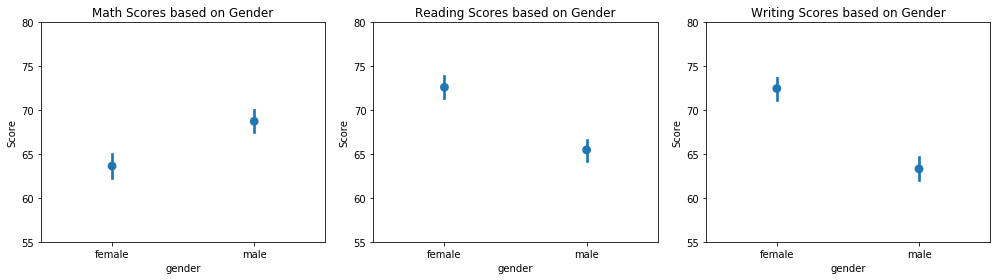

In [205]:
fig, (axis1, axis2, axis3) = plt.subplots(1,3,figsize=(14,4))

sns.pointplot(x = 'gender', y = 'math score', data = df, linestyles = '', ax = axis1)
sns.pointplot(x = 'gender', y = 'reading score', data = df, linestyles = '', ax = axis2)
sns.pointplot(x = 'gender', y = 'writing score', data = df, linestyles = '', ax = axis3)

axis1.set_title('Math Scores based on Gender')
axis2.set_title('Reading Scores based on Gender')
axis3.set_title('Writing Scores based on Gender')

for ax in [axis1, axis2, axis3]:
    ax.set_ylim([55, 80])
    ax.set_ylabel('Score') 

plt.tight_layout()

Before conducting a t-test, lets define the null hypothesis and set the p-value.  Here, the null hypothesis would be that the two samples being compared have no significant difference in exam scores.  The alternative hypothesis is that the two samples have significantly different exam scores.  The p-value is set at 0.05.  

In [215]:
def get_sample(var, subj, size, rnd_seed = 42):
    np.random.seed(rnd_seed)
    num = df[var].unique()
    for i in range(len(num)):
        for j in range(i+1, len(num)):
            samp1 = np.random.choice(df[df[var]==num[i]][subj], size, replace = True)
            samp2 = np.random.choice(df[df[var]==num[j]][subj], size, replace = True)
            print('T-test between {} and {} for {}.'.format(num[i], num[j], subj))
            print(ttest_ind(samp1, samp2, equal_var = False))
            print('')

Below are the t-test results for math, reading, and writing scores and gender. **All have a p-value of under 0.05, so the null hypothesis is rejected, meaning there is a significant difference in math, reading, and writing scores in terms of gender.**   

In [243]:
get_sample('gender', 'math score', 150)
get_sample('gender', 'reading score', 80)
get_sample('gender', 'writing score', 50)

T-test between female and male for math score.
Ttest_indResult(statistic=-4.4886415695614579, pvalue=1.0343344299282898e-05)

T-test between female and male for reading score.
Ttest_indResult(statistic=3.8839667019462722, pvalue=0.00015091828415510279)

T-test between female and male for writing score.
Ttest_indResult(statistic=2.0468343533924456, pvalue=0.043351410008108965)



#### 1.2 - Race/Ethnicity
Point plots for each subject matter are plotted below.  The general trend is that group A scores the worst and each subsequent group (alphabetical order) does better.  However due to overlapping confidence intervals, it is difficult to tell visually if they are statistically different.  The one exception would be math scores for group E, which has no overlap and clearly has a higher average than the other groups.

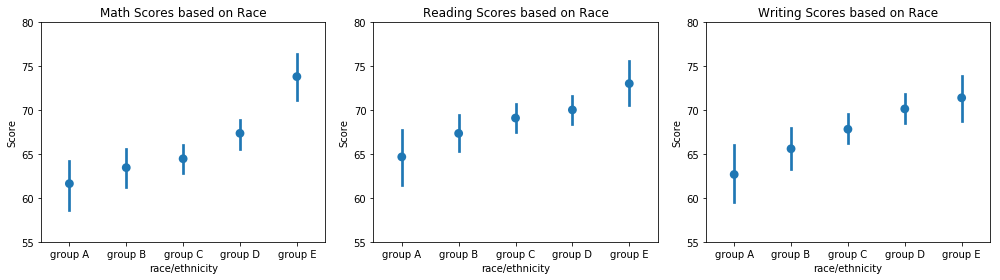

In [245]:
race_order = sorted(df['race/ethnicity'].unique())

fig, (axis1, axis2, axis3) = plt.subplots(1,3,figsize=(14,4))

sns.pointplot(x = 'race/ethnicity', y = 'math score', order = race_order, data = df, linestyles = '', ax = axis1)
sns.pointplot(x = 'race/ethnicity', y = 'reading score', order = race_order, data = df, linestyles = '', ax = axis2)
sns.pointplot(x = 'race/ethnicity', y = 'writing score', order = race_order, data = df, linestyles = '', ax = axis3)

axis1.set_title('Math Scores based on Race')
axis2.set_title('Reading Scores based on Race')
axis3.set_title('Writing Scores based on Race')

for ax in [axis1, axis2, axis3]:
    ax.set_ylim([55, 80])
    ax.set_ylabel('Score')

plt.tight_layout()

I will go through t-test results by subject matter.  First up is math.  The t-tests have mixed results, but **the general consensus is that group E is significantly different.  Group D is significantly different from groups A and C, and Groups A, B, and C are *not* significantly different from each other.  **

In [247]:
get_sample('race/ethnicity', 'math score', 150)

T-test between group B and group C for math score.
Ttest_indResult(statistic=-0.72442478948312006, pvalue=0.46938649232864849)

T-test between group B and group A for math score.
Ttest_indResult(statistic=1.5890103864058327, pvalue=0.11313616170859701)

T-test between group B and group D for math score.
Ttest_indResult(statistic=-1.5681123136506561, pvalue=0.11791612751573356)

T-test between group B and group E for math score.
Ttest_indResult(statistic=-5.6767451055071216, pvalue=3.2564656314564866e-08)

T-test between group C and group A for math score.
Ttest_indResult(statistic=-0.25634978755507498, pvalue=0.79785767205249547)

T-test between group C and group D for math score.
Ttest_indResult(statistic=-1.2888879521120264, pvalue=0.19844642366625079)

T-test between group C and group E for math score.
Ttest_indResult(statistic=-3.8426434099875109, pvalue=0.0001487835195124558)

T-test between group A and group D for math score.
Ttest_indResult(statistic=-2.5731269052662422, pvalue=

**Similar to math, for reading, group E is generally significantly different from the other groups.  The other groups are not significantly different from each other.  **

In [248]:
get_sample('race/ethnicity', 'reading score', 80)

T-test between group B and group C for reading score.
Ttest_indResult(statistic=-0.01951238613412741, pvalue=0.98445881673325752)

T-test between group B and group A for reading score.
Ttest_indResult(statistic=0.89332181640390274, pvalue=0.37304451173243747)

T-test between group B and group D for reading score.
Ttest_indResult(statistic=-0.83560046588446901, pvalue=0.40473523380590581)

T-test between group B and group E for reading score.
Ttest_indResult(statistic=-4.7862716248094008, pvalue=3.8769480718757165e-06)

T-test between group C and group A for reading score.
Ttest_indResult(statistic=1.5282134459889616, pvalue=0.1285345236130998)

T-test between group C and group D for reading score.
Ttest_indResult(statistic=0.63505639699690708, pvalue=0.52631317782986409)

T-test between group C and group E for reading score.
Ttest_indResult(statistic=-0.24655352762379756, pvalue=0.80557625217407369)

T-test between group A and group D for reading score.
Ttest_indResult(statistic=-0.621

**For writing, groups A and B are significantly different from group D, as are groups A and C.  The rest are not significantly different. **

In [249]:
get_sample('race/ethnicity', 'writing score', 50)

T-test between group B and group C for writing score.
Ttest_indResult(statistic=-0.77965113598069347, pvalue=0.43768908799183492)

T-test between group B and group A for writing score.
Ttest_indResult(statistic=-0.5025908950184298, pvalue=0.61638146283764716)

T-test between group B and group D for writing score.
Ttest_indResult(statistic=-2.1391405976637481, pvalue=0.034908792495769982)

T-test between group B and group E for writing score.
Ttest_indResult(statistic=-1.3540965355982979, pvalue=0.17892204143727941)

T-test between group C and group A for writing score.
Ttest_indResult(statistic=2.3713742511932194, pvalue=0.019713999581806536)

T-test between group C and group D for writing score.
Ttest_indResult(statistic=-0.51103000754728667, pvalue=0.6104867038453814)

T-test between group C and group E for writing score.
Ttest_indResult(statistic=-0.57100604393963617, pvalue=0.56933161698089396)

T-test between group A and group D for writing score.
Ttest_indResult(statistic=-3.3464

#### 1.3 - Parent's Level of Education
Lastly, we have parents level of education.  For all subject matters, it seems there is a clear divide in scores based on if the parents had at least some college education, where those parents who had at least some college have a higher score than those who did not.  Lets see if the t-tests say the same thing.

In [251]:
parent_edu_order = ['some high school', 'high school', 'some college', "associate's degree", "bachelor's degree", "master's degree"]

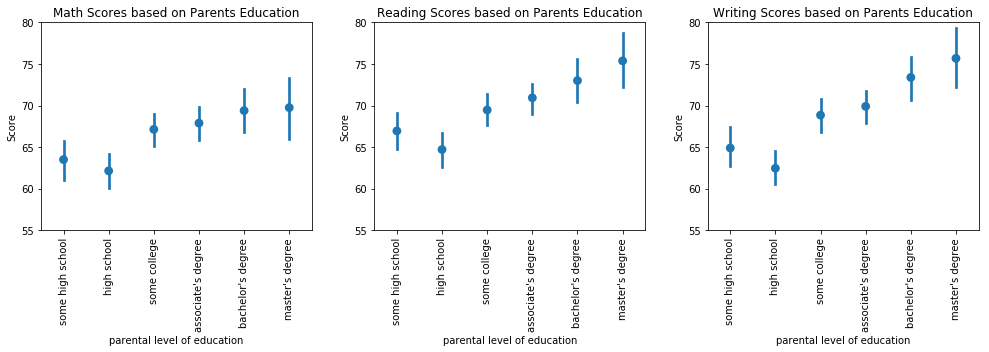

In [257]:
fig, (axis1, axis2, axis3) = plt.subplots(1,3,figsize=(14,5))

sns.pointplot(x = 'parental level of education', y = 'math score', order = parent_edu_order, data = df, linestyles = '', ax = axis1)
sns.pointplot(x = 'parental level of education', y = 'reading score', order = parent_edu_order, data = df, linestyles = '', ax = axis2)
sns.pointplot(x = 'parental level of education', y = 'writing score', order = parent_edu_order, data = df, linestyles = '', ax = axis3)

axis1.set_title('Math Scores based on Parents Education')
axis2.set_title('Reading Scores based on Parents Education')
axis3.set_title('Writing Scores based on Parents Education')

for ax in [axis1, axis2, axis3]:
    ax.set_ylim([55, 80])
    ax.set_ylabel('Score')
    for tick in ax.get_xticklabels():
        tick.set_rotation(90)   

plt.tight_layout()

As suspected, those with parents that have some or all of a high school education have significantly different scores from the other levels of parental education.  Those whose parents have some high school education have significantly different scores than those whose parents graduated high school, and perplexingly, also have higher scores.  The other two groups that are significantly different are those whose parents have some college education and those with a masters degree.  

In [262]:
get_sample('parental level of education', 'math score', 200)

T-test between bachelor's degree and some college for math score.
Ttest_indResult(statistic=-0.80472817324417534, pvalue=0.42148078384978271)

T-test between bachelor's degree and master's degree for math score.
Ttest_indResult(statistic=0.046362847771932281, pvalue=0.96304432208342972)

T-test between bachelor's degree and associate's degree for math score.
Ttest_indResult(statistic=1.0628924098934218, pvalue=0.28847631157228248)

T-test between bachelor's degree and high school for math score.
Ttest_indResult(statistic=4.92086314071123, pvalue=1.2868663425647658e-06)

T-test between bachelor's degree and some high school for math score.
Ttest_indResult(statistic=5.1161069849613305, pvalue=4.880681816032716e-07)

T-test between some college and master's degree for math score.
Ttest_indResult(statistic=-2.0372899544709706, pvalue=0.042293978107043634)

T-test between some college and associate's degree for math score.
Ttest_indResult(statistic=-1.2118647081603058, pvalue=0.226283134093

For reading scores, the differences aren't as straight forward.  Those whose parents have at least a high school education have significantly different scores than those with parents that have an associates, bachelors, or masters degree.  Lastly, those whose parents have a masters degree have scores significantly different than those with some college or an associates degree.

In [264]:
get_sample('parental level of education', 'reading score', 80)

T-test between bachelor's degree and some college for reading score.
Ttest_indResult(statistic=1.1497405630649691, pvalue=0.25200657063269066)

T-test between bachelor's degree and master's degree for reading score.
Ttest_indResult(statistic=-1.8185865591815193, pvalue=0.07087447383243127)

T-test between bachelor's degree and associate's degree for reading score.
Ttest_indResult(statistic=1.5613372203743847, pvalue=0.12047240858512448)

T-test between bachelor's degree and high school for reading score.
Ttest_indResult(statistic=6.567444059945692, pvalue=7.124832660117771e-10)

T-test between bachelor's degree and some high school for reading score.
Ttest_indResult(statistic=2.633665814225413, pvalue=0.0092890751146311283)

T-test between some college and master's degree for reading score.
Ttest_indResult(statistic=-2.9513310105649135, pvalue=0.0036485308981688844)

T-test between some college and associate's degree for reading score.
Ttest_indResult(statistic=-0.1093027788753213, pva

### 2) Are there any differences between the lunch types with respect to their performances in exams? If there are, how do you explain this?
Below I've plotted the math, reading, and writing scores based on lunch type.  Students who receive a standard lunch have an average score of at least 70 and those who receive the free/reduced lunch have scores in the mid 60s or below.  Confidence intervals do not overlap, so it seems pretty clear visually that the students receiving the two types of lunches have significantly different scores.  

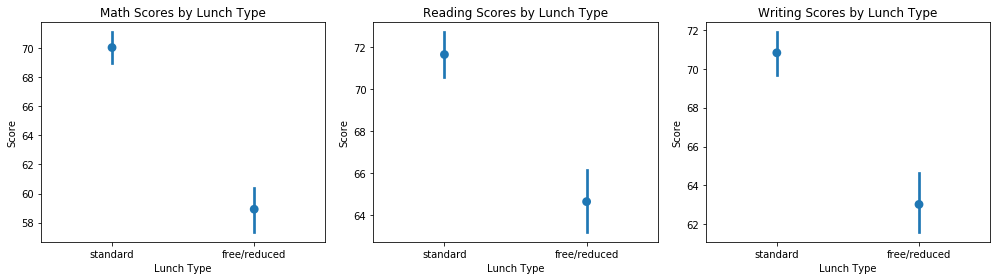

In [270]:
fig, (axis1, axis2, axis3) = plt.subplots(1,3,figsize=(14,4))

sns.pointplot(x = 'lunch', y = 'math score', linestyles='', data = df, ax = axis1)
sns.pointplot(x = 'lunch', y = 'reading score', linestyles='', data = df, ax = axis2)
sns.pointplot(x = 'lunch', y = 'writing score', linestyles='', data = df, ax = axis3)

axis1.set_title('Math Scores by Lunch Type')
axis2.set_title('Reading Scores by Lunch Type')
axis3.set_title('Writing Scores by Lunch Type')

for ax in [axis1, axis2, axis3]:
    ax.set_ylabel('Score')
    ax.set_xlabel('Lunch Type')

plt.tight_layout()

As always, a t-test should be used to confirm any results.  The null hypothesis can be established as student scores are not significantly different based on their lunch.  The alternative hypothesis is that student scores are significantly different based on their lunch.  **If the p-value is set at 0.05, then the null hypothesis is rejected for all subjects, which is consistent with what we see visually.**

In [278]:
get_sample('lunch', 'math score', 200)
get_sample('lunch', 'reading score', 200)
get_sample('lunch', 'writing score', 200)

T-test between standard and free/reduced for math score.
Ttest_indResult(statistic=6.9888265636132649, pvalue=1.2282699703402992e-11)

T-test between standard and free/reduced for reading score.
Ttest_indResult(statistic=4.5442447619076063, pvalue=7.3710675904463017e-06)

T-test between standard and free/reduced for writing score.
Ttest_indResult(statistic=5.2003559790102454, pvalue=3.2294691193029494e-07)



### 3) Does the test preparation course seem to have an effect on the exam performances?
From the point plot below, the means scores of the students who completed the preparation course are higher than the scores of those who didn't for all subjects.  Confidence intervals do not overlap so by a purely visual inspection, it seems that taking the preparation course had an effect on exam performances.  

To confirm, I perform a t-test.  The null hypothesis is the mean score of students who took the preparation course is not significantly different than the mean score of those who did not take the preparation course.  The alternative hypothesis is that the mean score is different depending on if the student took the preparation course or not.  **Below shows that the p-values are below 0.05, so I reject the null hypothesis and there taking the preparation course does have an effect on student scores.**

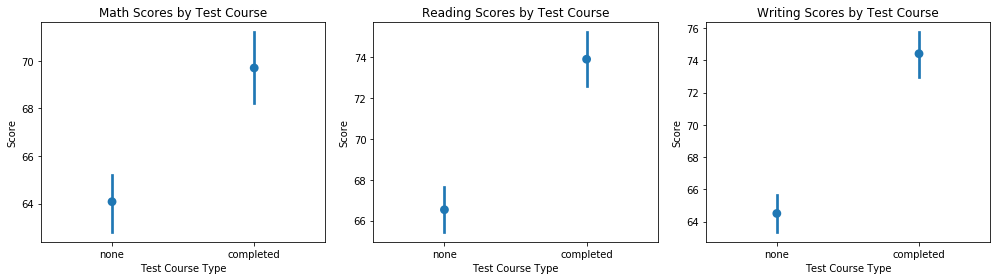

In [286]:
fig, (axis1, axis2, axis3) = plt.subplots(1,3,figsize=(14,4))

sns.pointplot(x = 'test preparation course', y = 'math score', linestyles='', data = df, ax = axis1)
sns.pointplot(x = 'test preparation course', y = 'reading score', linestyles='', data = df, ax = axis2)
sns.pointplot(x = 'test preparation course', y = 'writing score', linestyles='', data = df, ax = axis3)

axis1.set_title('Math Scores by Test Course')
axis2.set_title('Reading Scores by Test Course')
axis3.set_title('Writing Scores by Test Course')

for ax in [axis1, axis2, axis3]:
    ax.set_ylabel('Score')
    ax.set_xlabel('Test Course Type')

plt.tight_layout()

In [288]:
get_sample('test preparation course', 'math score', 200)
get_sample('test preparation course', 'reading score', 200)
get_sample('test preparation course', 'writing score', 200)

T-test between none and completed for math score.
Ttest_indResult(statistic=-2.4201074485201084, pvalue=0.015965962586051475)

T-test between none and completed for reading score.
Ttest_indResult(statistic=-4.101127361049854, pvalue=5.0012701912133785e-05)

T-test between none and completed for writing score.
Ttest_indResult(statistic=-6.0956297354993128, pvalue=2.601871774462876e-09)



### 5) Which 2 exam scores are most correlated with each other?
Below is a heat map of the correlations, where the lighter the color, the higher the correlation is.  From this heat map, the 2 exam scores most correlated with each other are reading and writing.  

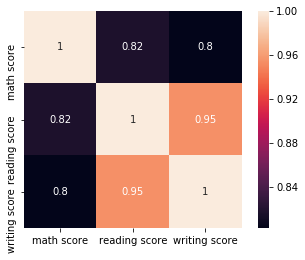

In [291]:
sns.heatmap(df.corr(), square = True, annot = True)